In [1]:
#!pip install pandas
#%matplotlib inline
import math
import numpy as np
import pandas as pd
import pandasql as ps
import scipy.stats as stats
import matplotlib.pyplot as plt
from pandas.api.types import CategoricalDtype
import IPython.display as ipd

import ast

from collections import defaultdict
from scipy.stats.stats import pearsonr

plt.rcParams['axes.formatter.useoffset']=False
pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv('flat_df_no_nulli.csv', index_col=0)

In [3]:
df

,ALBUM_date_released_year,ALBUM_favorites,ALBUM_type,ALBUM_tags,ALBUM_tracks,ALBUM_listens,ALBUM_title,SET_subset,ARTIST_favorites,ARTIST_location,ARTIST_tags,ARTIST_name,TRACK_duration,TRACK_favorites,TRACK_genre_top,TRACK_genres_all,TRACK_genres,TRACK_interest,TRACK_listens,TRACK_tags,TRACK_title,TRACK_bitrate,TRACK_number,rmsekurtosis01,rmsemax01,rmsemean01,rmsemedian01,rmsemin01,rmseskew01,rmsestd01,spectral_bandwidthkurtosis01,spectral_bandwidthmax01,spectral_bandwidthmean01,spectral_bandwidthmedian01,spectral_bandwidthmin01,spectral_bandwidthskew01,spectral_bandwidthstd01,spectral_centroidkurtosis01,spectral_centroidmax01,spectral_centroidmean01,spectral_centroidmedian01,spectral_centroidmin01,spectral_centroidskew01,spectral_centroidstd01,spectral_rolloffkurtosis01,spectral_rolloffmax01,spectral_rolloffmean01,spectral_rolloffmedian01,spectral_rolloffmin01,spectral_rolloffskew01,spectral_rolloffstd01,zcrkurtosis01,zcrmax01,zcrmean01,zcrmedian01,zcrmin01,zcrskew01,zcrstd01,TRACK_genres_soloTop,ARTIST_favorites_,ALBUM_tracks_,ALBUM_listens_,ALBUM_favorites_,ALBUM_type_,ALBUM_date_released_year_,Blues,Classical,Country,Easy Listening,Electronic,Experimental,Folk,Hip-Hop,Instrumental,International,Jazz,Old-Time / Historic,Pop,Rock,Soul-RnB,Spoken,chroma_censkurtosis,chroma_censmax,chroma_censmean,chroma_censmedian,chroma_censmin,chroma_censskew,chroma_censstd,chroma_censcqtkurtosis,chroma_cqtmax,chroma_cqtmean,chroma_cqtmedian,chroma_cqtmin,chroma_cqtskew,chroma_cqtstd,chroma_stftkurtosis,chroma_stftmax,chroma_stftmean,chroma_stftmedian,chroma_stftmin,chroma_stftskew,chroma_stftstd,mfcckurtosis,mfccmax,mfccmean,mfccmedian,mfccmin,mfccskew,mfccstd,spectral_contrastkurtosis,spectral_contrastmax,spectral_contrastmean,spectral_contrastmedian,spectral_contrastmin,spectral_contrastskew,spectral_contraststd,tonnetzkurtosis,tonnetzmax,tonnetzmean,tonnetzmedian,tonnetzmin,tonnetzskew,tonnetzstd,ARTIST_location_
track_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,2009.0,4.0,Album,[],7.0,6073.0,AWOL - A Way Of Life,small,2.302585,New Jersey,['awol'],AWOL,168,1.098612,Hip-Hop,[21],['21'],8.446127,7.165493,[],Food,256000,3,2.499856,14.748096,3.188761,2.653895,0.000000,1.565426,2.536809,3.874384,3451.105957,1607.474365,1618.850098,0.000000,-0.884317,436.808990,2.406808,5514.049805,1639.583252,1503.496704,0.000000,1.079815,719.770508,0.840540,9410.009766,3267.804688,3143.847656,0.000000,0.347372,1300.729736,5.758890,0.459473,0.085629,0.071289,0.000000,2.089872,0.061448,['Hip-Hop'],9.0,3.0,7.165493,1.098612,Album,2009.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.279389,0.112555,-0.143922,-0.165123,-0.028040,-2.740602,0.132277,4.372140,-0.002102,-0.159066,-0.262436,-0.092806,-2.184695,0.028168,-0.975603,-0.000779,0.149664,-0.164355,-0.016616,0.589170,-0.006238,-0.753965,-63.770708,-54.514267,-62.362546,-24.629408,0.383883,14.101151,1.668064,-2.545115,-7.407170,-8.389809,-1.293357,-1.189231,0.746760,1.335255,-0.069000,0.063224,-0.055764,0.206749,-0.152102,-0.075675,North America
3,2009.0,4.0,Album,[],7.0,6073.0,AWOL - A Way Of Life,medium,2.302585,New Jersey,['awol'],AWOL,237,0.693147,Hip-Hop,[21],['21'],7.293698,6.244167,[],Electric Ave,256000,4,-0.643963,9.096919,3.607359,3.706424,0.000000,0.018619,1.952665,2.383340,3469.176514,1736.961426,1686.766602,0.000000,0.464217,486.662476,3.519866,6288.426758,1763.012451,1517.993652,0.000000,1.652693,972.758423,2.379145,10002.172852,3514.619629,3413.012695,0.000000,1.118952,1650.357788,2.824694,0.466309,0.084578,0.063965,0.000000,1.716724,0.069330,['Hip-Hop'],9.0,4.0,6.244167,0.693147,Album,2009.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.348105,0.141263,0.148353,0.165589,-0.028040,-0.832174,0.120936,-1.078200,-0.002102,-0.242421,-0.303482,-0.092806,-1.014772,0.037748,-1.800064,-0.000779,-0.111860,0.160687,-0.016616,-0.667940,-0.044654,-0.336291,-72.777076,-59.487557,-66.

In [5]:
X = df[["TRACK_favorites", "ALBUM_listens_", "TRACK_interest", "TRACK_listens", "TRACK_number", "ARTIST_favorites_", "ALBUM_tracks_", "ALBUM_favorites_", "TRACK_duration"]].values

## LOF

In [7]:
from sklearn.neighbors import LocalOutlierFactor

In [65]:
clf = LocalOutlierFactor(n_neighbors=3)
outliers = clf.fit_predict(X)

In [66]:
clf.negative_outlier_factor_

array([-1.09156162, -1.03054012, -1.14568285, ..., -1.29765915,
       -0.94830693, -1.00437338])

In [67]:
np.unique(outliers, return_counts=True)

(array([-1,  1]), array([  2197, 103338], dtype=int64))

In [68]:
outliers_LOF = np.where(outliers==-1)

In [12]:
clf.negative_outlier_factor_[np.where(outliers==-1)]

array([-1.52104053, -1.55930625, -1.51538595, ..., -1.64155709,
       -1.50686308, -1.73878627])

In [13]:
np.max(clf.negative_outlier_factor_[np.where(outliers==-1)])

-1.5000936799555356

In [14]:
np.min(clf.negative_outlier_factor_[np.where(outliers==-1)])

-156.10300796750997

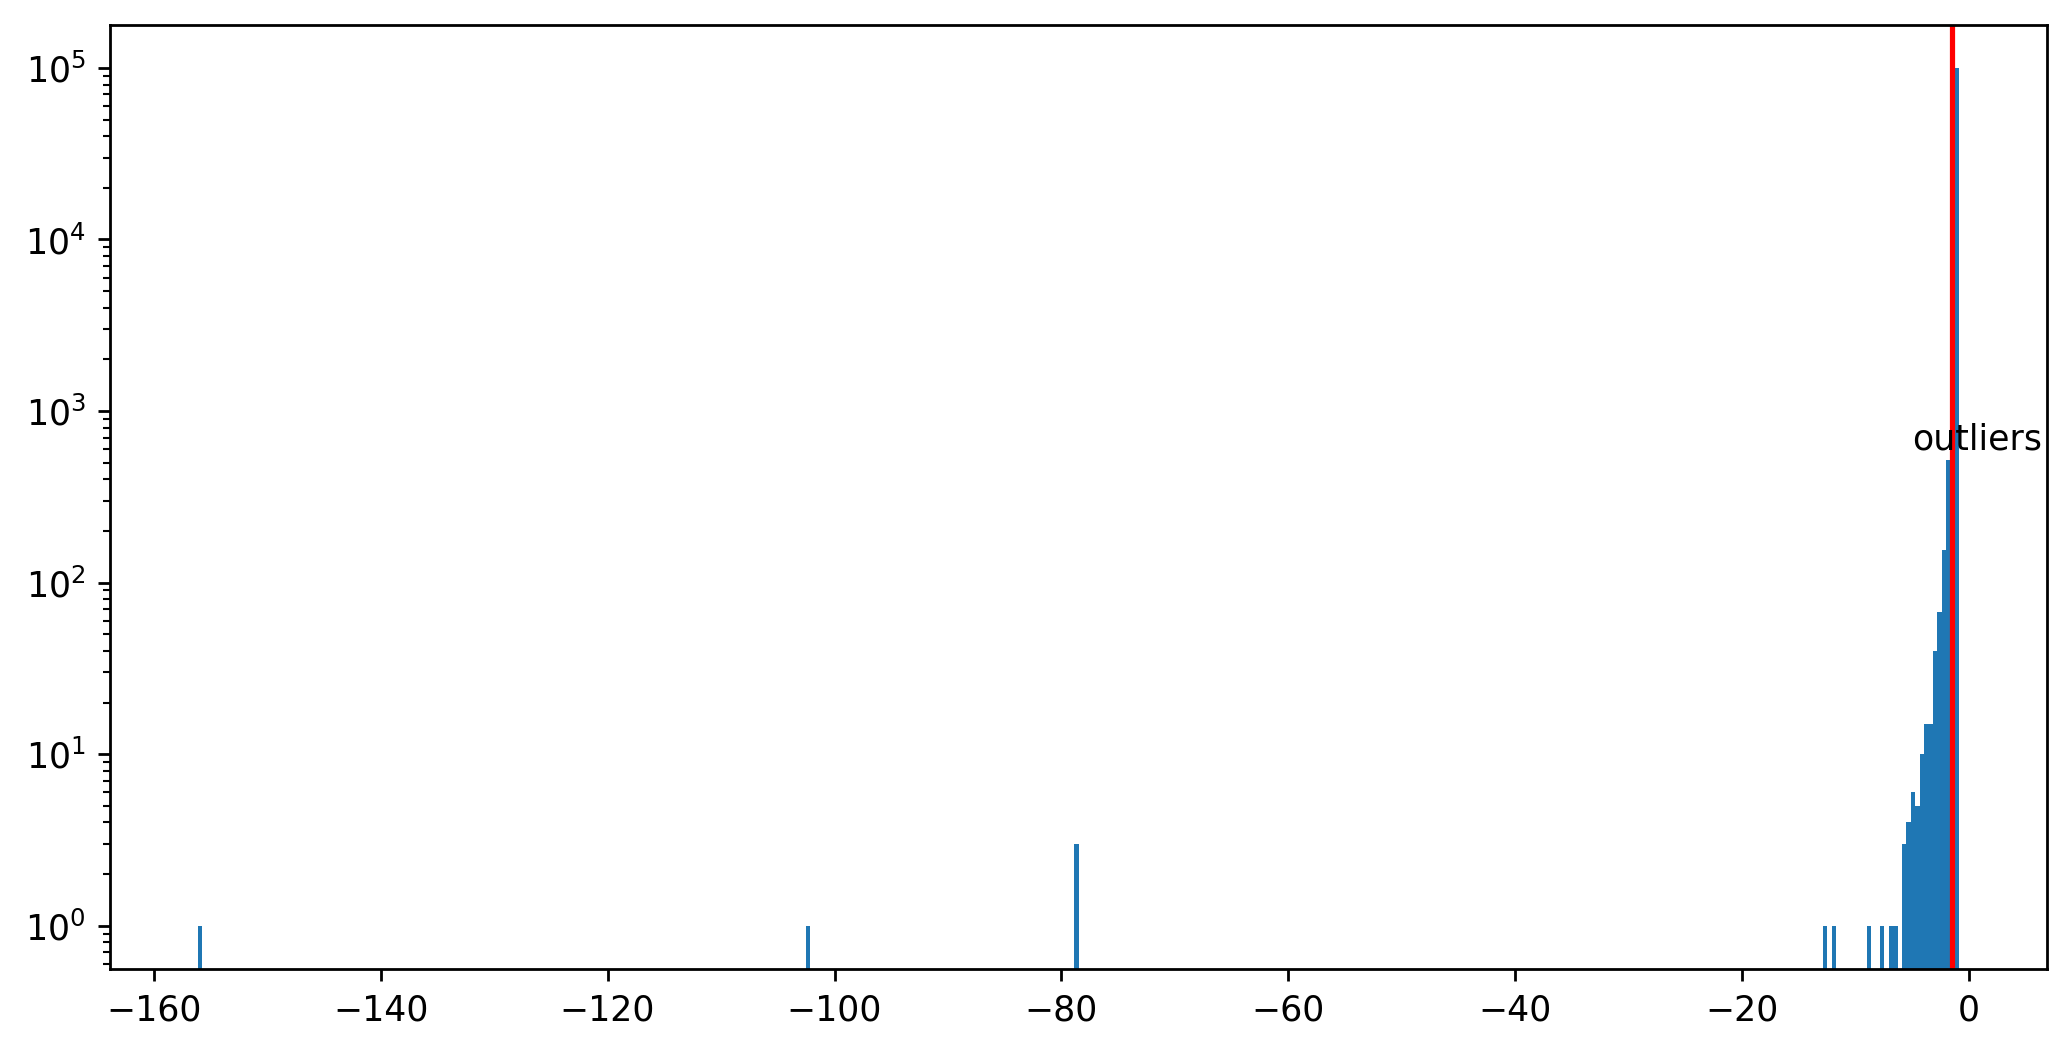

In [31]:
plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.dpi'] = 250


plt.hist(clf.negative_outlier_factor_, bins=400)
plt.axvline(-1.5, c='r')
plt.text(-5, 600, 'outliers')
plt.yscale("log")
plt.show()

In [25]:
res = list()

for i in clf.negative_outlier_factor_:
    if i > -80:
        res.append(i)

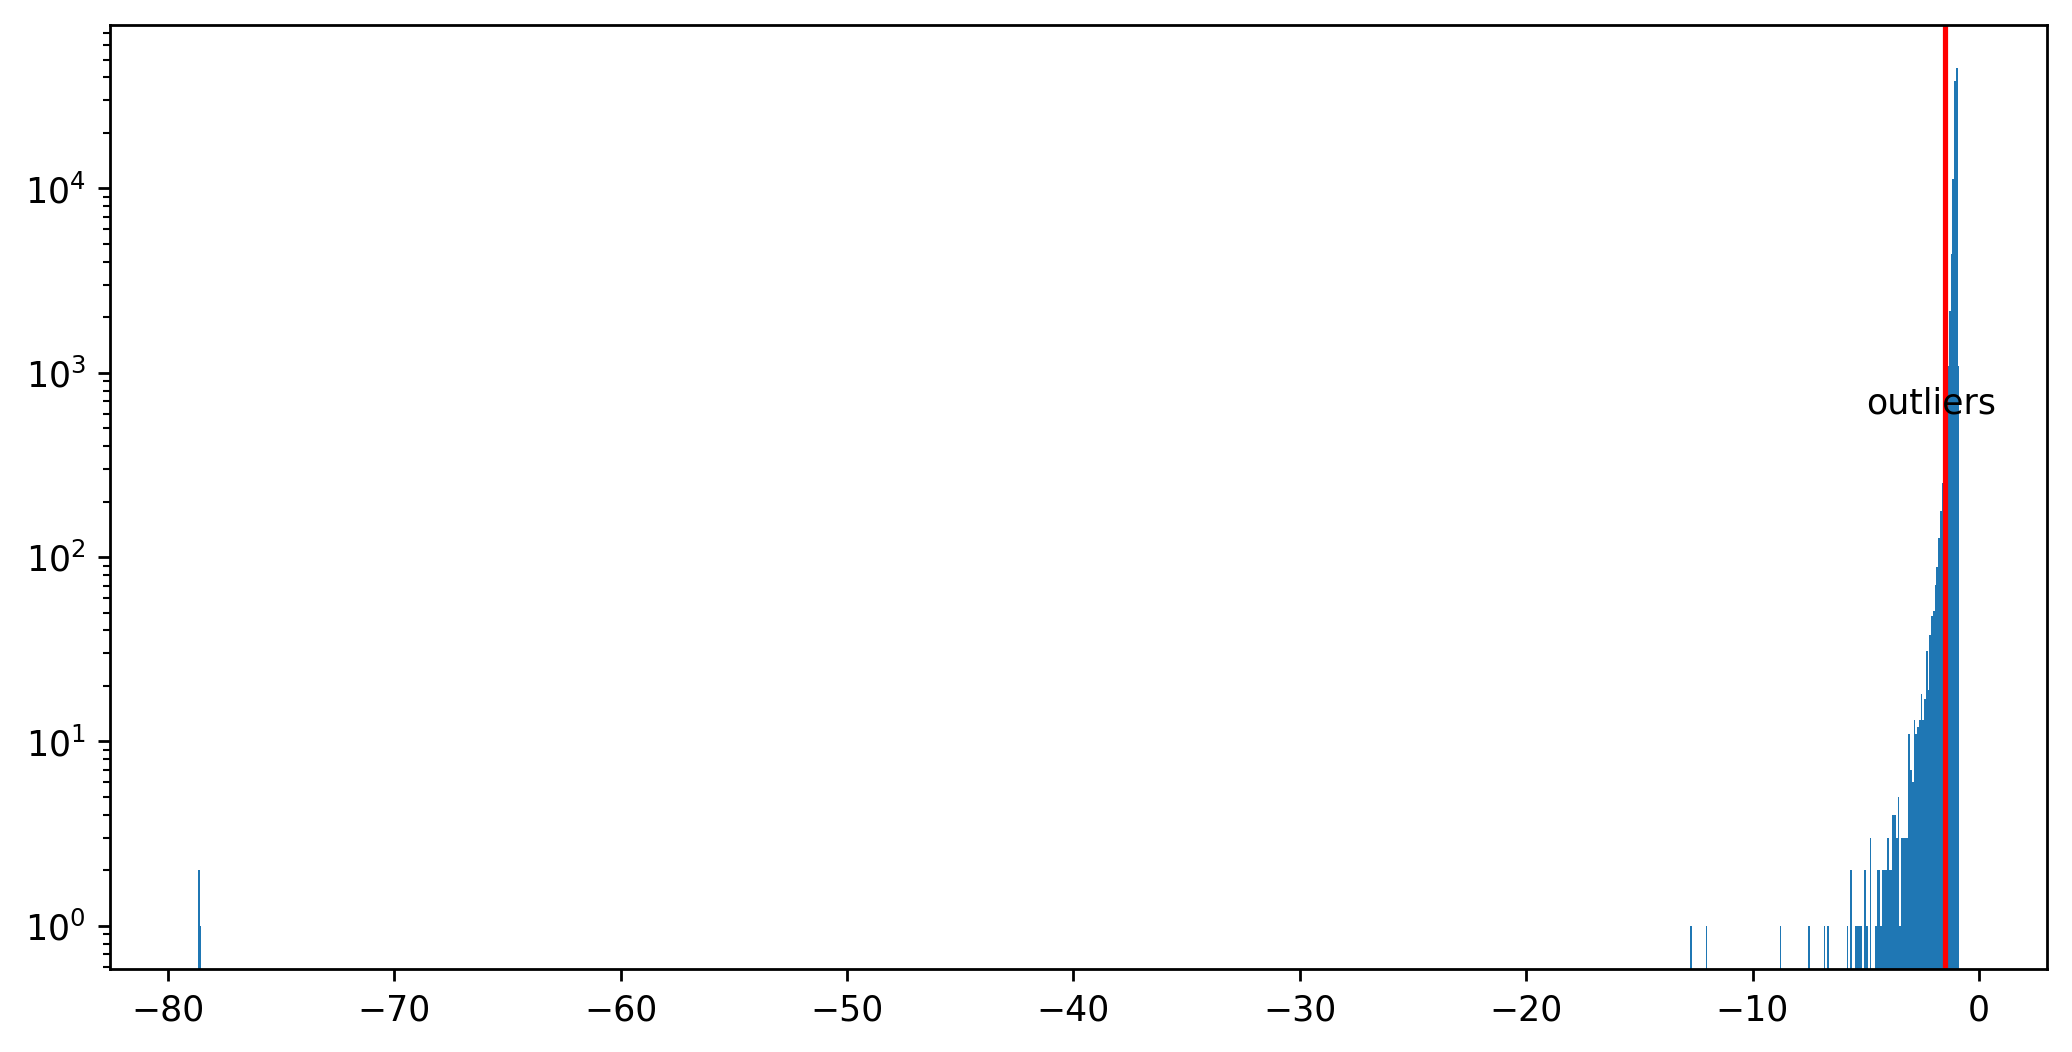

In [33]:
plt.hist(res, bins=1000)
plt.axvline(-1.5, c='r')
plt.text(-5, 600, 'outliers')
plt.yscale("log")
plt.show()

In [24]:
res

[-102.42592272174201, -156.10300796750997]

## ABOD

In [36]:
from pyod.models.abod import ABOD
from pyod.models.knn import KNN
#from pyod.models.lof import LOF
from pyod.models.loci import LOCI
from pyod.models.auto_encoder import AutoEncoder

In [37]:
clf = ABOD(contamination=.03)
clf.fit(X)

ABOD(contamination=0.03, method='fast', n_neighbors=5)

In [38]:
clf.decision_scores_

array([-0.00478823, -0.00978262, -0.00962271, ..., -0.00189387,
       -0.68439388, -0.01452061])

In [59]:
outliers = clf.predict(X)
outliers_ABOD = np.where(outliers==1)
np.unique(outliers, return_counts=True)

(array([0, 1]), array([96633,  8902], dtype=int64))

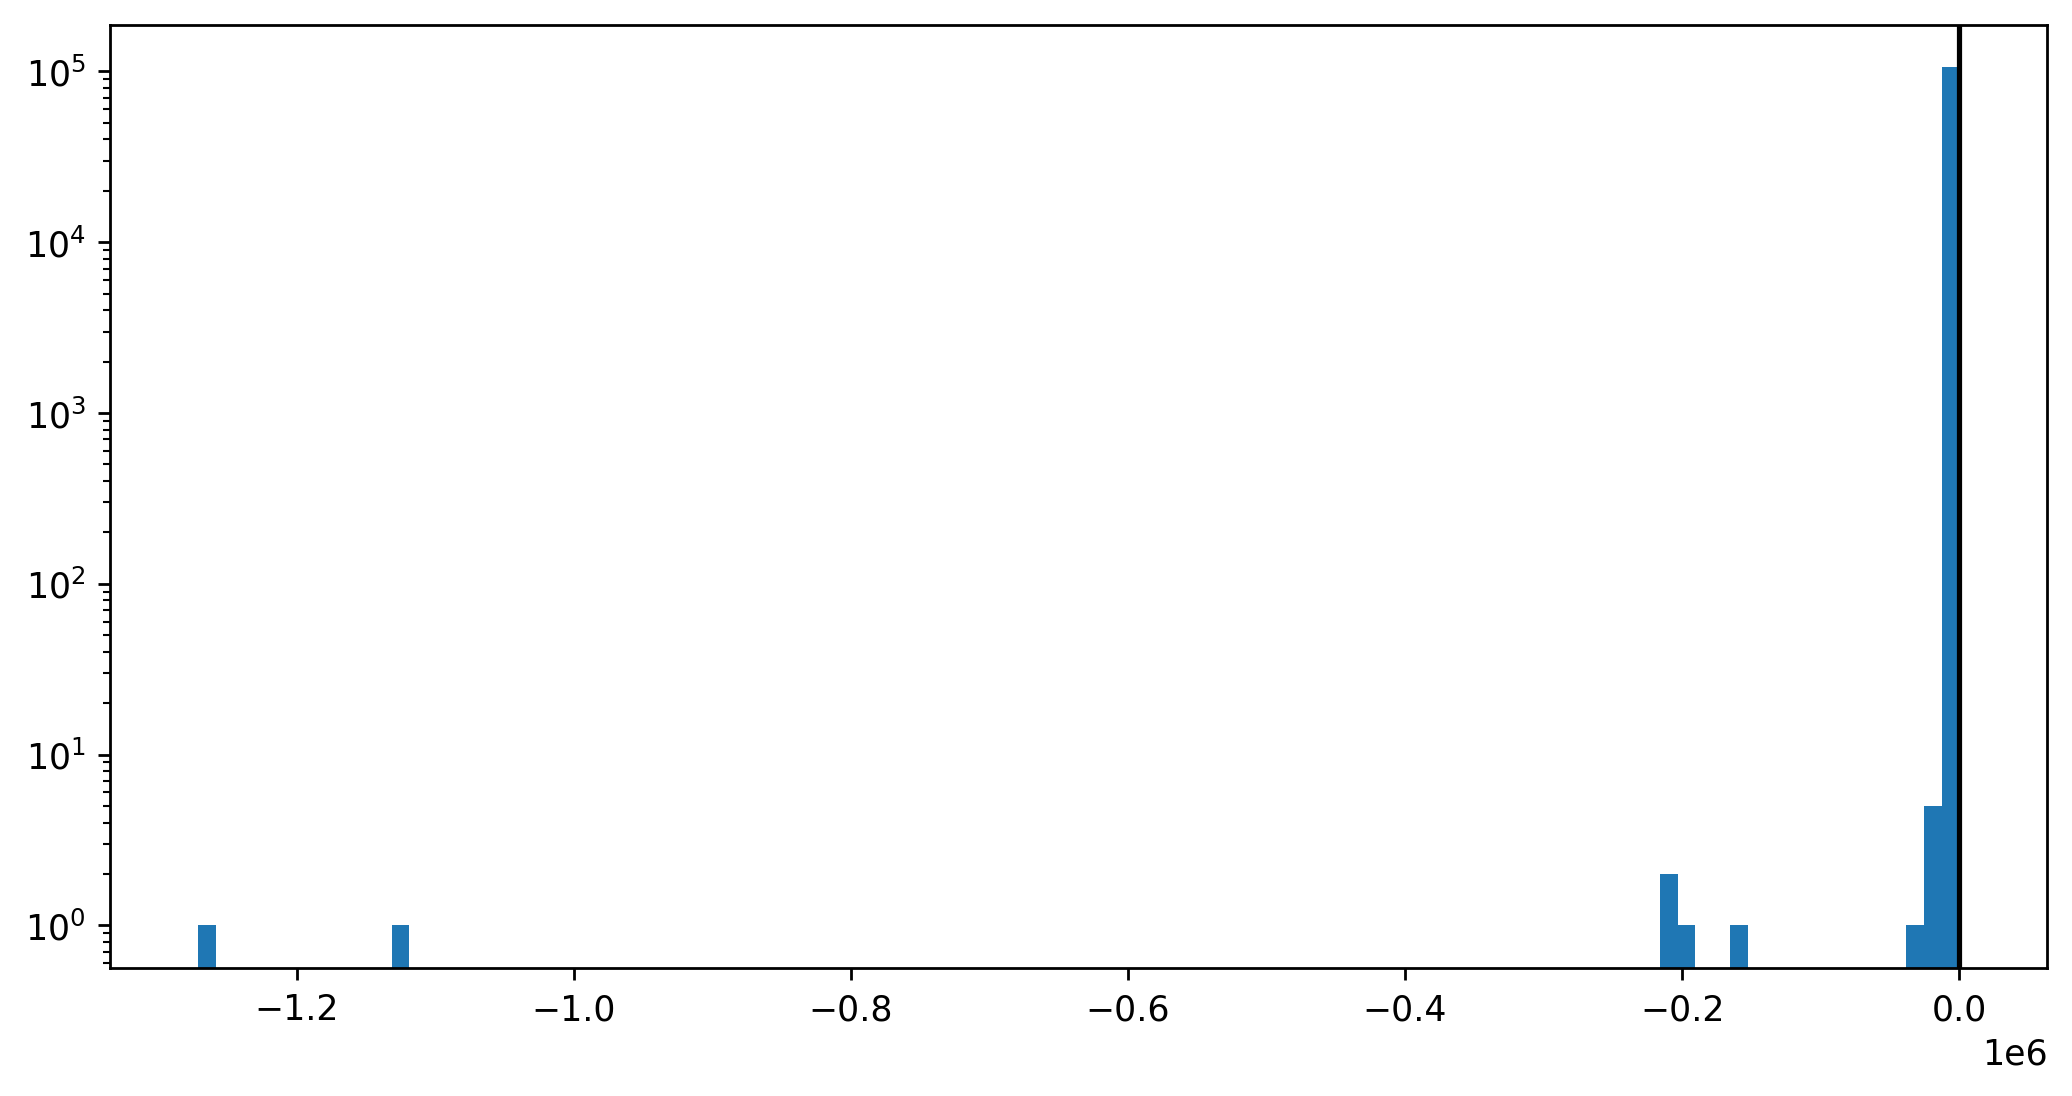

In [43]:
plt.hist(clf.decision_scores_, bins=100)
plt.axvline(np.max(clf.decision_scores_[np.where(outliers==1)]), c='k')
plt.yscale("log")
plt.show()

## KNN

In [44]:
clf = KNN()
clf.fit(X)

KNN(algorithm='auto', contamination=0.1, leaf_size=30, method='largest',
  metric='minkowski', metric_params=None, n_jobs=1, n_neighbors=5, p=2,
  radius=1.0)

In [45]:
clf.decision_scores_

array([2.23826037, 2.09506491, 2.147503  , ..., 2.1965707 , 1.39284901,
       2.08947339])

In [46]:
anomlay_score = clf.decision_function(X)

In [60]:
outliers = clf.predict(X)
np.unique(outliers, return_counts=True)

(array([0, 1]), array([96633,  8902], dtype=int64))

In [48]:
np.mean(anomlay_score[np.where(outliers==1)])

15.397290301161329

In [49]:
np.mean(anomlay_score[np.where(outliers==0)])

2.6601890207200243

In [50]:
np.mean(clf.decision_scores_[np.where(outliers==1)])

17.742229957900857

In [51]:
np.mean(clf.decision_scores_[np.where(outliers==0)])

2.8340672825928266

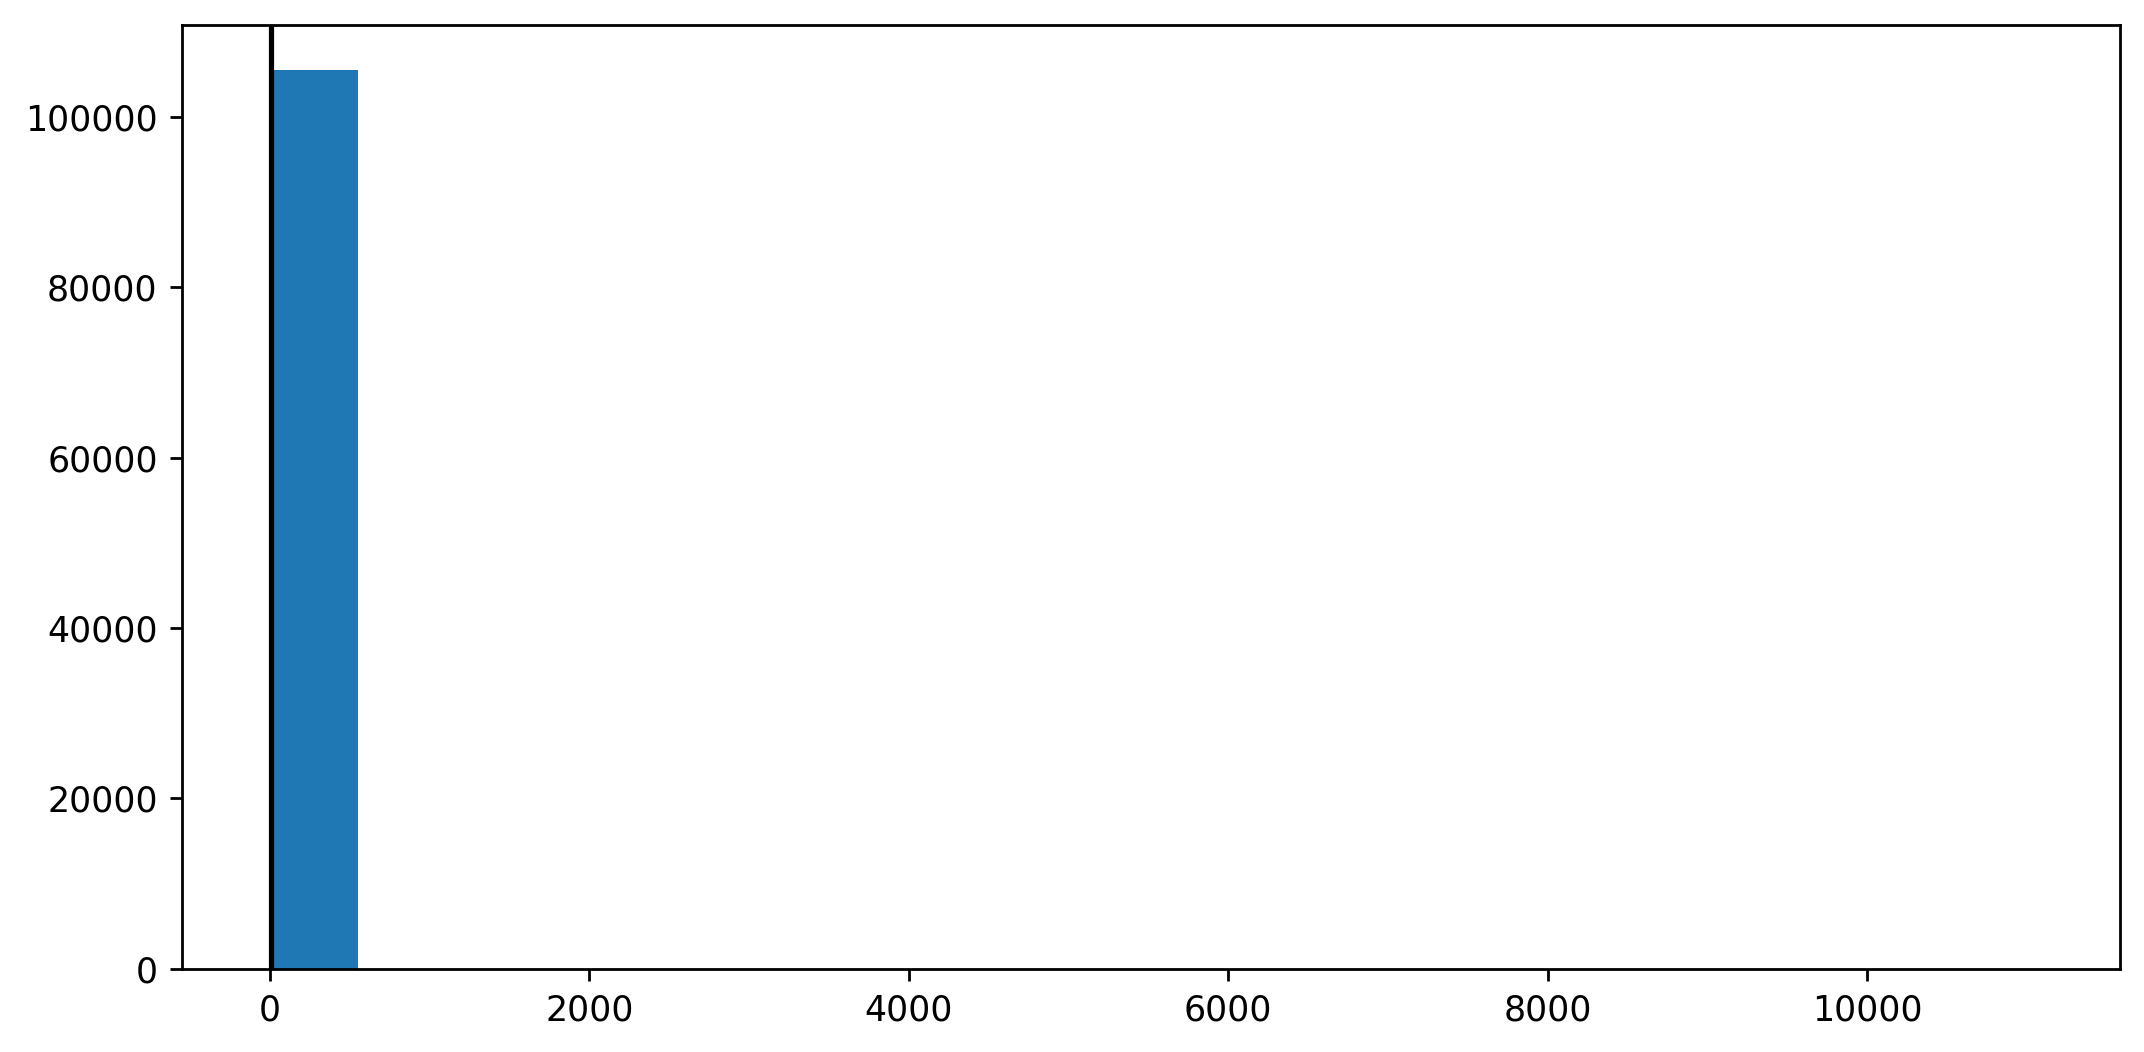

In [52]:
plt.hist(clf.decision_scores_, bins=20)
plt.axvline(np.min(clf.decision_scores_[np.where(outliers==1)]), c='k')
plt.show()

In [61]:
outliers_knn = np.where(outliers==1)

In [71]:
outliers_intersecati = np.intersect1d(np.intersect1d(outliers_knn, outliers_ABOD), outliers_LOF)

In [72]:
len(outliers_intersecati)

1063

In [64]:
105535 * .01

1055.35

In [76]:
df.drop(df.index[outliers_intersecati], inplace=True)

In [78]:
df.to_csv("flat_df_no_nulli_no_outliers.csv")